In [1]:
import numpy as np
import scipy.stats
import scipy as scp
import sklearn
import sklearn.covariance
import sklearn.cluster
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.collections 
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# Make data

In [2]:
mean = np.zeros(6)
cov = [[   1, .29, .49, .10, .30,  0],
        [ .29,   1,-.49, .49, .40,  0],
        [ .49,-.49,   1,   0,   0,  0],
        [ .10, .49,   0,   1,   0,  0],
        [ .30, .40,   0,   0,   1,  0],
        [   0,   0,   0,   0,   0,  1]]

In [3]:
X = scp.stats.multivariate_normal.rvs(mean=mean,cov=cov,size=300,random_state=5)
#x4 correlate with x6
X[:,3] += 0.6*X[:,5]
#x5 correlate with x6
X[:,4] += 0.6*X[:,5]
df_X = pd.DataFrame(X,columns=['X{0}'.format(i+1) for i in range(6)])

# Check Data

To understand the data by looking at the pair plot

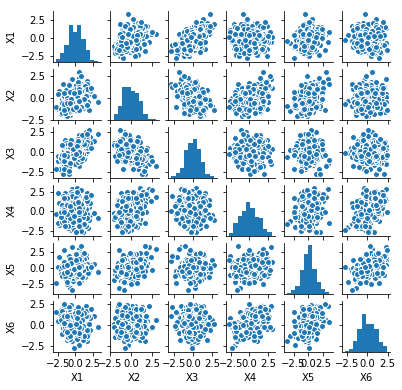

In [4]:
f = sns.pairplot(df_X)
f.fig.set_figheight(5)
f.fig.set_figwidth(5)
f.fig.set_facecolor('w')

Pseudo correlation appears in the plot of X4 vs X6

Determine the covariance matrix with normal method as follow:   
\begin{eqnarray}   
    \Sigma ={\rm Cov}({\bf X}) = {\rm E}\left[ {\rm ( \bf X - {\rm E}[X] )( \bf X - {\rm E}[X] )^{\rm T}  }\right]
\end{eqnarray}   
Correlation matrix as folow:   
\begin{eqnarray}   
    {\rm C} &=& D\Sigma D \\
    D_{ij} &=& ({\rm diag}({\rm \Sigma}))^{-1/2}\Sigma\,({\rm diag}({\rm \Sigma}))^{-1/2}
\end{eqnarray}  

In [5]:
Cov_nom = df_X.cov()
Pre_nom = np.matrix(Cov_nom)**-1

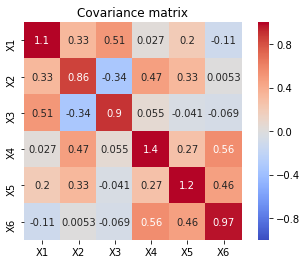

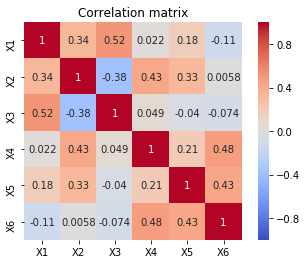

In [6]:
h = sns.heatmap(Cov_nom,cmap='coolwarm',square=True,annot=True,vmin=-1,vmax=1)
h.figure.set_facecolor('w')
h.set_title('Covariance matrix')
plt.show()

h = sns.heatmap(df_X.corr(),cmap='coolwarm',square=True,annot=True,vmin=-1,vmax=1)
h.figure.set_facecolor('w')
h.set_title('Correlation matrix')
plt.show()

In [7]:
# check pandas correlation function
def cov2corr(cov):
    cov_nom = np.array(cov)
    D = np.diag(np.power(np.diag(np.array(cov_nom)),-0.5))
    return np.dot(np.dot(D,cov_nom),D)
#pd.DataFrame(np.dot(np.dot(np.diag(np.power(np.diag(Cov_nom**-1),0.5)),np.matrix(Cov_nom)),np.diag(np.power(np.diag(Cov_nom**-1),0.5))))

partial correlation matrix - is often used as a method of finding pseudo correlation.    
partial correlation matrix define as follow:   
\begin{eqnarray}   
    r_{ij,k} = \frac{r_{ij} - r_{ki}r_{kj}}{\sqrt{1-r_{ki}^2}\sqrt{1-r_{kj}^2}}
\end{eqnarray}
$r_{ij,k}$ is the correlation coefficient between "$x_i$ excluding the influence of $x_k$" and "$x_j$ excluding the influence of $x_k$".   
$r_{ij}$ is the correlation coefficient between components $x_i$ and $x_j$.

In [8]:
def cov2partialcorr(cov):
    omega=np.linalg.inv(np.array(cov))
    D=np.diag(np.power(np.diag(omega),-0.5))
    partialcorr=-np.dot(np.dot(D,omega),D)
    #convert diagonal component　from -1 to 1
    partialcorr+=2*np.eye(cov.shape[0])
    return partialcorr

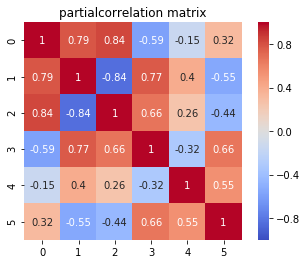

In [9]:
h = sns.heatmap(cov2partialcorr(Cov_nom),cmap='coolwarm',square=True,annot=True,vmin=-1,vmax=1)
h.figure.set_facecolor('w')
h.set_title('partialcorrelation matrix')
plt.show()

Calculating the partial correlation matrix using the covariance matrix calculated from the data is affected by noise,    
so the data structure is not well understood.

# Graphical Lasso

A multigraph assuming a multivariate normal distribution is called a Gaussian graphic model.   
By using the precision matrix $\Lambda = (\Sigma^{-1})$which is a parameter of this distribution, 
we can see the relationship of variables as a graphic model.    
That is, the i and j elements $\lambda_{ij}$.   
If it is not 0, there is a direct correlation between $x_i$ and $x_j$.

データxが多変量正規分布に従うとすると、データの分布は

\begin{eqnarray}
    \mathcal{N}({\bf x}|{\bf 0},\Lambda^{-1}) \sim \frac{|\Lambda|^{1/2}}{(2\pi)^{M/2}}\exp\left(-\frac{1}{2}{\bf x}^{t}\Lambda {\bf x}\right)
\end{eqnarray}

スパースな精度行列を求めるために, ラプラス分布の事前分布を仮定してデータから事後分布を計算する。   
事後分布は、   
\begin{eqnarray}   
   p(\Lambda |{\bf D}) &\propto&  p(\Lambda)\prod^{N-1}_{i=0}\mathcal{N}({\bf x}^{(i)}| {\bf 0},\Lambda)　\\
   {\bf D} &=& \left\{ {\bf x}^{(i)}\right\}_{i=0}^{N-1}
\end{eqnarray}

したがって、$\Lambda$の推定量$\hat\Lambda$は、

\begin{eqnarray}   
   \hat\Lambda = {\rm arg} \max_\Lambda \left\{ \ln {\rm det}\Lambda-{\rm tr}({\rm S}\Lambda) - \alpha||\Lambda||_{1} \right\}
\end{eqnarray}    
Sは、標本分散行列

In [10]:
alpha = 0.2
model = sklearn.covariance.GraphicalLasso(alpha=alpha,
                                           max_iter=100,                     
                                           verbose=True,
                                           assume_centered = True)
model.fit(df_X)

[graphical_lasso] Iteration   0, cost  2.80e+01, dual gap 4.965e-01
[graphical_lasso] Iteration   1, cost  2.79e+01, dual gap -3.057e-04
[graphical_lasso] Iteration   2, cost  2.79e+01, dual gap -5.331e-06


GraphicalLasso(alpha=0.2, assume_centered=True, enet_tol=0.0001, max_iter=100,
        mode='cd', tol=0.0001, verbose=True)

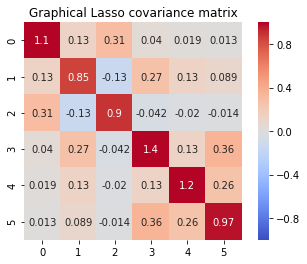

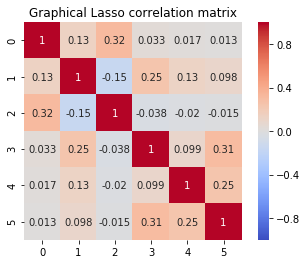

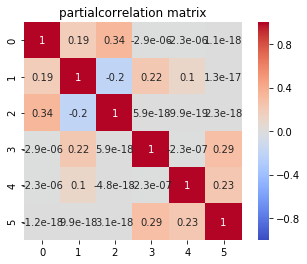

In [11]:
h=sns.heatmap(model.covariance_,cmap='coolwarm',square=True,annot=True,vmin=-1,vmax=1)
h.figure.set_facecolor('w')
h.set_title('Graphical Lasso covariance matrix')
plt.show()

h=sns.heatmap(cov2corr(model.covariance_),cmap='coolwarm',square=True,annot=True,vmin=-1,vmax=1)
h.figure.set_facecolor('w')
h.set_title('Graphical Lasso correlation matrix')
plt.show()

h=sns.heatmap(cov2partialcorr(model.covariance_),cmap='coolwarm',square=True,annot=True,vmin=-1,vmax=1)
h.figure.set_facecolor('w')
h.set_title('partialcorrelation matrix')
plt.show()

# Versus Markov graph

[参考](https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html#sphx-glr-auto-examples-applications-plot-stock-market-py)

feature value clustering with affinity propagation

In [12]:
_, labels = sklearn.cluster.affinity_propagation(model.covariance_)
n_labels = labels.max()
names = df_X.columns.values
for i in range(n_labels+1):
    print('Cluster {0}: {1}'.format(i+1,names[labels==i]))

Cluster 1: ['X1' 'X3']
Cluster 2: ['X2' 'X4' 'X6']
Cluster 3: ['X5']


Locally Linear Embedding

In [13]:
node_position_model = sklearn.manifold.LocallyLinearEmbedding(n_components=2, eigen_solver='dense', n_neighbors=5)
embedding = node_position_model.fit_transform(df_X.T).T
d = 1./np.sqrt(np.diag(model.precision_))
partialcorr = cov2partialcorr(model.covariance_)
non_zero = (np.abs(np.triu(partialcorr,k=1))>0.02)

In [14]:
non_zero

array([[False,  True,  True, False, False, False],
       [False, False,  True,  True,  True, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False,  True],
       [False, False, False, False, False,  True],
       [False, False, False, False, False, False]])

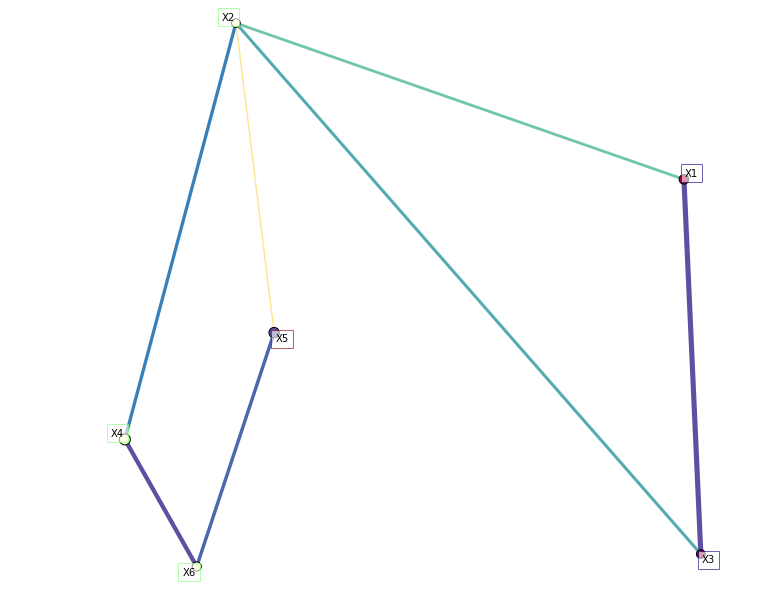

In [15]:
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')
plt.scatter(embedding[0], embedding[1], s=100*d**2,edgecolors='k', c=labels,cmap='Spectral')

start_idx, end_idx = np.where(non_zero)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partialcorr[non_zero])
lc = matplotlib.collections.LineCollection(segments,
                                           zorder=0, cmap=plt.cm.Spectral,
                                           norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.jet(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()